## Multi-Class Logistic Regression on MNISIT(Digits)

The goal of this notebook is to show how we performed the SoftMax regression (a generalization of logistic regression to more than two categories) on the MNIST (Digits) handwritten dataset. We will compare our implementation with that of Scikit Logistic regression package.

In [10]:
import MCLogReg as mclr
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, roc_auc_score

In [11]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "/Users/endriasa/Projects/FYS4155/Project-2/Figures"
FIGURE_ID = "Figures"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", dpi=100,pad_inches=0.0,transparent=False, bbox_inches='tight',format='png')

## Loading the data and plotting

Input Data Shape (1797, 64)
Label Data Shape (1797,)


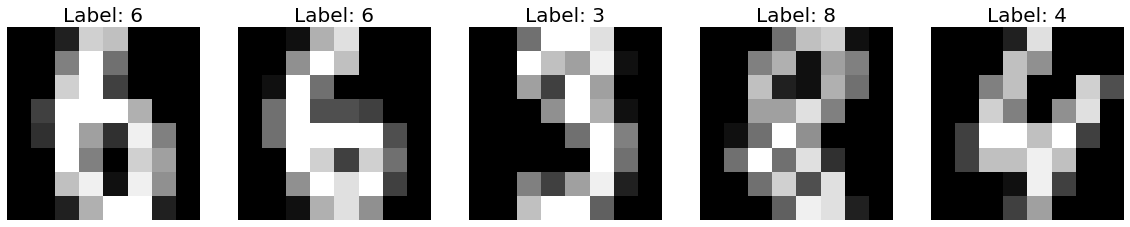

In [12]:
# ensure the same random numbers appear every time
np.random.seed(2020)

# download MNIST dataset
digits = datasets.load_digits()

# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Input Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)

# define inputs and labels
inputs = digits.images
labels = digits.target

# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs   = inputs.reshape(n_inputs, -1)

# choose some random images to display
indices        = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

plt.figure(figsize=(20,4))
for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title("Label: %d" % digits.target[random_indices[i]],fontsize=20)
save_fig('Digits_data')    
plt.show()    

## Splitting the data into traning and test sets

In [13]:
train_size = 0.8
test_size  = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,test_size=test_size)

## Scaling the data to have zero mean and unit variance

In [14]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Cross validated grid search for finding the optimal $\eta$ and $\lambda$

In [6]:
neta       = 4
nlmb       = 4
etavec     = np.logspace(-4, -1, neta)
lmbvec     = np.logspace(-1, -4, nlmb)
lmbvec[0]  = 0.0
epochs     = 10000
batch_size = X_train.shape[0]//32

nk               = 5
logreg           = mclr.MCLogReg()
y_folds, x_folds = logreg.k_fold_reshaper(nk,Y_train,X_train,shuffle=True)

acc_train     = np.zeros([neta,nlmb])
acc_test      = np.zeros([neta,nlmb])
logloss_train = np.zeros([epochs,neta,nlmb])
logloss_test  = np.zeros([epochs,neta,nlmb])

for ie, eta in enumerate(etavec):
    
    for jm, lmb in enumerate(lmbvec):
        
        for i in range(nk):
    
            x_train = x_folds[np.arange(len(x_folds))!=i]      
            x_train = np.concatenate(x_train,axis=0)
            y_train = y_folds[np.arange(len(y_folds))!=i]
            y_train = np.concatenate(y_train,axis=0)
            x_test  = x_folds[i]
            y_test  = y_folds[i]
    
            logreg  = mclr.MCLogReg(eta = eta, lamb=lmb)
            cost_test, cost_train, axis, beta = logreg.fit(x_train, y_train, x_test, y_test, Niter=epochs, 
                                                           batch_size=batch_size,solver='sgd')
    
            pred_train = logreg.predict(x_train)
            pred_test  = logreg.predict(x_test)

            acc_train_tmp = logreg.compute_accuracy(pred_train, y_train)
            acc_test_tmp  = logreg.compute_accuracy(pred_test, y_test)
            
            acc_test[ie,jm]        += acc_test_tmp
            acc_train[ie,jm]       += acc_train_tmp
            logloss_train[:,ie,jm] += cost_train
            logloss_test[:,ie,jm]  += cost_test
    
acc_train     = acc_train/nk
acc_test      = acc_test/nk
logloss_train = logloss_train/nk
logloss_test  = logloss_test/nk

C_train = logloss_train[-1,:,:]
C_test  = logloss_test[-1,:,:]


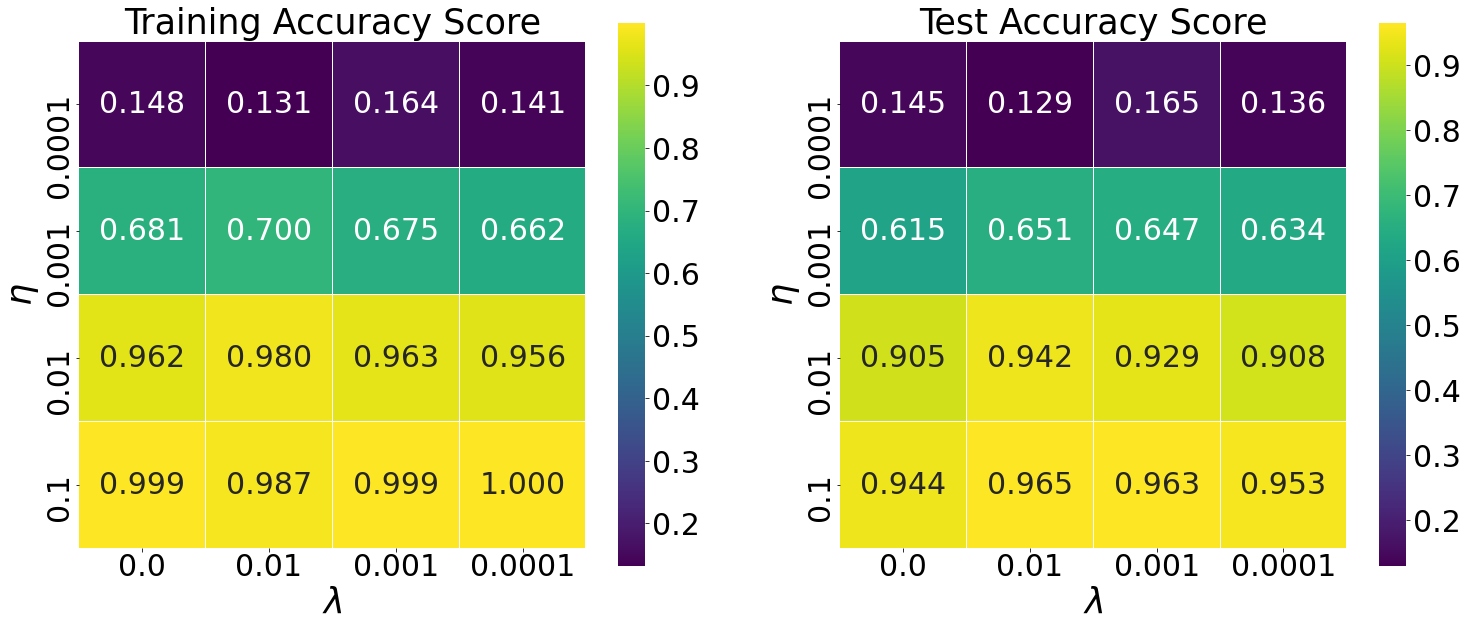

In [7]:
yticklabels = etavec
xticklabels = lmbvec

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(acc_train, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Training Accuracy Score'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(acc_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test Accuracy Score'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
save_fig('LogReg_CV_eta_lmb_SGD')
plt.show()

## Multi-class logistic regression (using our code and scikit)

In [15]:
# Set the learning rate, the number of iterations, and the regulirization parameter
eta        = 0.1 
epochs     = 10000
lam        = 0.01
batch_size = X_train.shape[0]//32

# Call the regression class and perform fitting
logreg = mclr.MCLogReg(eta = eta, lamb=lam)
cost_test, cost_train, axis, beta = logreg.fit(X_train, Y_train, X_test, Y_test, Niter=epochs, 
                                               batch_size=batch_size, solver='sgd')

# Sklearn logistic regressor
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, Y_train)

# Prediction on the training and test data sets
pred_train = logreg.predict(X_train)
pred_test  = logreg.predict(X_test)

# Sklearn prediction on the training and test data sets
pred_test_sk  = logisticRegr.predict(X_test)
pred_train_sk = logisticRegr.predict(X_train)

# Evaluate the performance using the accuracy error metric
acc_train = logreg.compute_accuracy(pred_train, Y_train)
acc_test  = logreg.compute_accuracy(pred_test, Y_test)

# Sklearn evaluate the performance using the accuracy error metric
acc_test_sk  = accuracy_score(pred_test_sk, Y_test)
acc_train_sk = accuracy_score(pred_train_sk, Y_train)

print("Training acc.:" ,acc_train)
print("Training acc. Sk:" ,acc_train_sk)
print("Test acc.:" ,acc_test)
print("Test acc. Sk:" ,acc_test_sk)

Training acc.: 0.9853862212943633
Training acc. Sk: 0.9993041057759221
Test acc.: 0.9527777777777777
Test acc. Sk: 0.9694444444444444


## Confusion Matrix  (using our code and scikit)

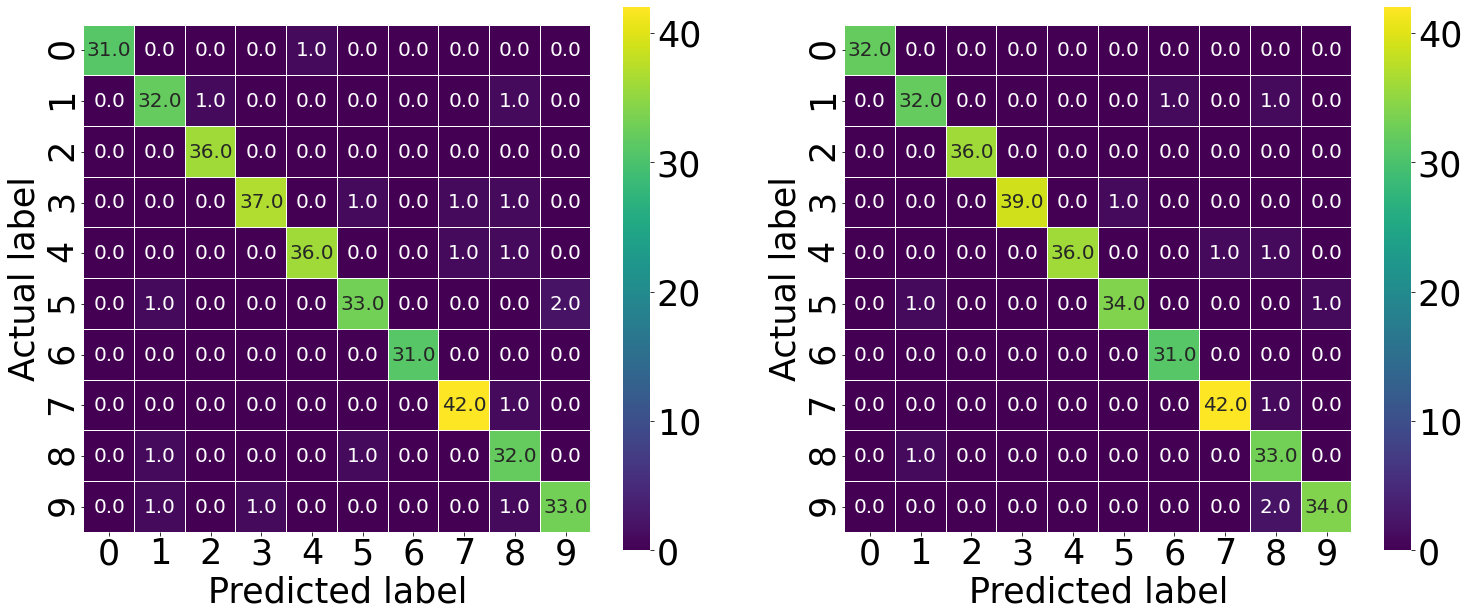

In [17]:
cm    = metrics.confusion_matrix(Y_test, pred_test)
cm_sk = metrics.confusion_matrix(Y_test, pred_test_sk)

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.025,  
               square = True, cmap = "viridis",annot_kws={"size": 20});
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)
plt.ylabel('Actual label',fontsize=35);
plt.xlabel('Predicted label',fontsize=35);
#all_sample_title = 'Test Accuracy Score'
#plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=35,pad=1)
ax.tick_params(axis='y', which='major', labelsize=35,pad=1)


ax=plt.subplot(1,2,2)
sns.heatmap(cm_sk, annot=True, fmt=".1f", linewidths=.025,  
               square = True, cmap = "viridis",annot_kws={"size": 20});
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)
plt.ylabel('Actual label',fontsize=35);
plt.xlabel('Predicted label',fontsize=35);
#all_sample_title = 'Test Accuracy Score (Scikit)'
#plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=35,pad=1)
ax.tick_params(axis='y', which='major', labelsize=35,pad=1)

save_fig('Digits_confusionM')
plt.show();

## Multi-class logistic regression with K-fold cross validation (using our code)

In [46]:
# Set the learning rate, the number of iterations, and the regularization parameter
eta        = 0.1 
epochs     = 10000
lam        = 0.01
batch_size = X_train.shape[0]//32

# Call the regression class and perform fitting
logreg           = mclr.MCLogReg(eta = eta, lamb=lam)
logisticRegr     = LogisticRegression()
nk               = 5
y_folds, x_folds = logreg.k_fold_reshaper(nk,Y_train,X_train,shuffle=True)

acc_train     = float()
acc_test      = float()
cm_train      = np.zeros([10,10])
cm_test       = np.zeros([10,10])
acc_train_sk  = float()
acc_test_sk   = float()
cm_train_sk   = np.zeros([10,10])
cm_test_sk    = np.zeros([10,10])
logloss_train = np.zeros([epochs,1])
logloss_test  = np.zeros([epochs,1])

for i in range(nk):
    
    x_train = x_folds[np.arange(len(x_folds))!=i]      
    x_train = np.concatenate(x_train,axis=0)
    y_train = y_folds[np.arange(len(y_folds))!=i]
    y_train = np.concatenate(y_train,axis=0)
    x_test  = x_folds[i]
    y_test  = y_folds[i]
    
    cost_test, cost_train, axis, beta = logreg.fit(x_train, y_train, x_test, y_test, Niter=epochs, 
                                               batch_size=batch_size, solver='sgd')
    logisticRegr.fit(x_train, y_train)

    pred_train = logreg.predict(x_train)
    pred_test  = logreg.predict(x_test)
    
    pred_test_sk  = logisticRegr.predict(x_test)
    pred_train_sk = logisticRegr.predict(x_train)

    acc_train_tmp = logreg.compute_accuracy(pred_train, y_train)
    acc_test_tmp  = logreg.compute_accuracy(pred_test, y_test)
    
    acc_test_sk_tmp  = accuracy_score(pred_test_sk, y_test)
    acc_train_sk_tmp = accuracy_score(pred_train_sk, y_train)

    cm_test_tmp  = metrics.confusion_matrix(y_test, pred_test)
    cm_train_tmp = metrics.confusion_matrix(y_train, pred_train)

    cm_test_sk_tmp  = metrics.confusion_matrix(y_test, pred_test_sk)
    cm_train_sk_tmp = metrics.confusion_matrix(y_train, pred_train_sk)
    
    acc_test      += acc_test_tmp
    acc_train     += acc_train_tmp
    cm_test       += cm_test_tmp
    cm_train      += cm_train_tmp
    acc_test_sk   += acc_test_sk_tmp
    acc_train_sk  += acc_train_sk_tmp
    cm_test_sk    += cm_test_sk_tmp
    cm_train_sk   += cm_train_sk_tmp
    cost_train     = np.array(cost_train)
    cost_test      = np.array(cost_test)
    logloss_train += cost_train.reshape(-1,1)
    logloss_test  += cost_test.reshape(-1,1)
    
acc_train     = acc_train/nk
acc_test      = acc_test/nk
cm_test       = cm_test/nk
cm_train      = cm_train/nk
acc_train_sk  = acc_train_sk/nk
acc_test_sk   = acc_test_sk/nk
cm_test_sk    = cm_test_sk/nk
cm_train_sk   = cm_train_sk/nk
logloss_train = logloss_train/nk
logloss_test  = logloss_test/nk

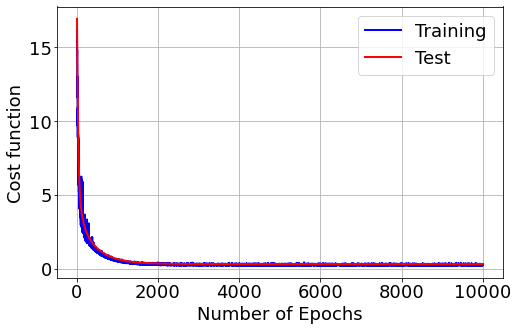

In [63]:
fig, ax = plt.subplots(figsize=(8,5))  
plt.plot(axis, cost_train, 'b', label='Training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Test', linewidth=2)
plt.legend(fontsize=18)
plt.grid()
plt.ylabel('Cost function',fontsize=18)
plt.xlabel('Number of Epochs',fontsize=18)
ax.tick_params(axis='x', which='major', labelsize=18,pad=1)
ax.tick_params(axis='y', which='major', labelsize=18,pad=1)
save_fig('Digits_CV_Loss')
plt.show()

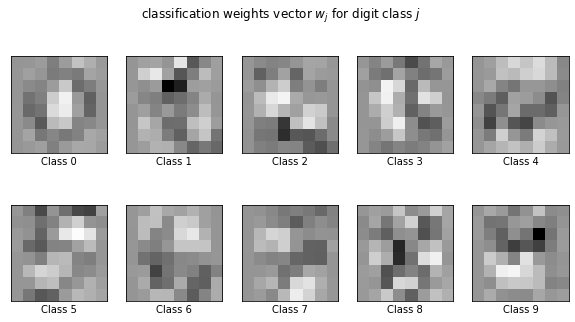

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot weights vs the pixel position
plt.figure(figsize=(10, 5))
scale = np.abs(beta).max()
beta  = beta[:,1::]

for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(beta[i].reshape(8, 8), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    l2_plot.set_xlabel('Class %i' % i)
plt.suptitle('classification weights vector $w_j$ for digit class $j$')

plt.show()